In [2]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [3]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")
TRAIN_ZIP = "X:/Guviprojects/projectsss/train-20251031T044439Z-1-001.zip"
VALID_ZIP = "X:/Guviprojects/projectsss/valid-20251031T044440Z-1-001.zip"
TEST_ZIP  = "X:/Guviprojects/projectsss/test-20251031T044435Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")
    
    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting X:/Guviprojects/projectsss/train-20251031T044439Z-1-001.zip ...
Extracted to data_extracted_fixed\train
Found train folder candidate: data_extracted_fixed\train\train
Extracting X:/Guviprojects/projectsss/valid-20251031T044440Z-1-001.zip ...
Extracted to data_extracted_fixed\valid
Extracting X:/Guviprojects/projectsss/test-20251031T044435Z-1-001.zip ...
Extracted to data_extracted_fixed\test
✅ Found valid dataset directory: data_extracted_fixed\train\train
✅ Found valid dataset directory: data_extracted_fixed\valid\valid
✅ Found valid dataset directory: data_extracted_fixed\test\test

Final dataset directories:
Train dir: data_extracted_fixed\train\train
Valid dir: data_extracted_fixed\valid\valid
Test dir:  data_extracted_fixed\test\test

Sample structure check:
data_extracted_fixed\train\train -> 4 class folders
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [4]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [5]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (128, 224, 224, 3)
Sample label batch shape: (128,)


In [6]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [7]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


x:\Guviprojects\projectsss\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3522 - loss: 1.8085

14/14 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.4094 - loss: 1.6305 - val_accuracy: 0.3207 - val_loss: 1.3738
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4959 - loss: 1.4132

14/14 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - accuracy: 0.5339 - loss: 1.2908 - val_accuracy: 0.3207 - val_loss: 1.3638
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.5888 - loss: 1.1247 - val_accuracy: 0.3207 - val_loss: 1.3655
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.6035 - loss: 1.0832 - val_accuracy: 0.3207 - val_loss: 1.3832
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.6195 - loss: 1.0621 - val_accuracy: 0.3207 - val_loss: 1.4150
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.6254 - loss: 0.9850 - val_accuracy: 0.3207 - val_loss: 1.4642


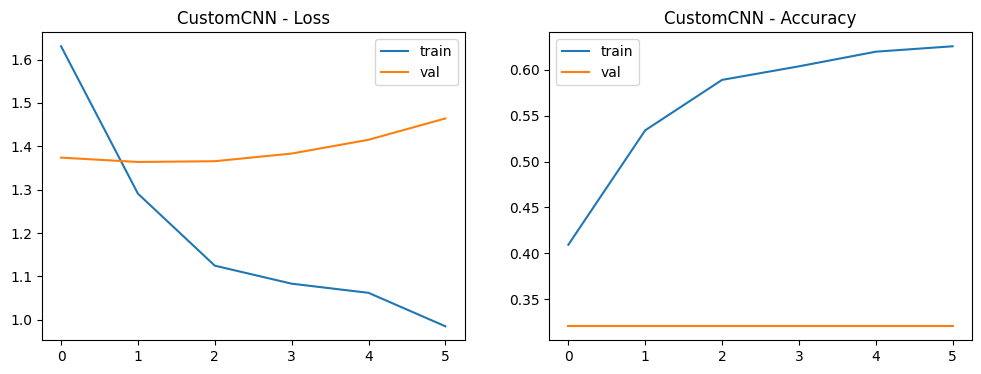


Training ResNet50 ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2480 - loss: 1.4980

14/14 ━━━━━━━━━━━━━━━━━━━━ 183s 13s/step - accuracy: 0.2578 - loss: 1.4896 - val_accuracy: 0.2709 - val_loss: 1.3758
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2344 - loss: 1.4817

14/14 ━━━━━━━━━━━━━━━━━━━━ 150s 11s/step - accuracy: 0.2513 - loss: 1.4664 - val_accuracy: 0.3207 - val_loss: 1.3687
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3006 - loss: 1.4376

14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.2991 - loss: 1.4348 - val_accuracy: 0.3207 - val_loss: 1.3684
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2967 - loss: 1.4449 

14/14 ━━━━━━━━━━━━━━━━━━━━ 172s 13s/step - accuracy: 0.2997 - loss: 1.4456 - val_accuracy: 0.3207 - val_loss: 1.3643
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2922 - loss: 1.4269

14/14 ━━━━━━━━━━━━━━━━━━━━ 173s 13s/step - accuracy: 0.2962 - loss: 1.4236 - val_accuracy: 0.3207 - val_loss: 1.3592
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2756 - loss: 1.4500 

14/14 ━━━━━━━━━━━━━━━━━━━━ 172s 13s/step - accuracy: 0.3009 - loss: 1.4352 - val_accuracy: 0.3267 - val_loss: 1.3534
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3046 - loss: 1.4050

14/14 ━━━━━━━━━━━━━━━━━━━━ 172s 12s/step - accuracy: 0.3109 - loss: 1.4129 - val_accuracy: 0.3287 - val_loss: 1.3498
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3009 - loss: 1.4390

14/14 ━━━━━━━━━━━━━━━━━━━━ 170s 12s/step - accuracy: 0.3086 - loss: 1.4211 - val_accuracy: 0.3267 - val_loss: 1.3433
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2772 - loss: 1.4237

14/14 ━━━━━━━━━━━━━━━━━━━━ 169s 12s/step - accuracy: 0.2796 - loss: 1.4214 - val_accuracy: 0.3426 - val_loss: 1.3393
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2965 - loss: 1.4210

14/14 ━━━━━━━━━━━━━━━━━━━━ 152s 11s/step - accuracy: 0.3056 - loss: 1.4151 - val_accuracy: 0.3486 - val_loss: 1.3354
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3056 - loss: 1.4042

14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.3127 - loss: 1.4000 - val_accuracy: 0.3566 - val_loss: 1.3310
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3202 - loss: 1.4006

14/14 ━━━━━━━━━━━━━━━━━━━━ 135s 10s/step - accuracy: 0.3168 - loss: 1.4029 - val_accuracy: 0.3625 - val_loss: 1.3271
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3243 - loss: 1.3902

14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.3233 - loss: 1.3899 - val_accuracy: 0.3924 - val_loss: 1.3235
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3084 - loss: 1.4077

14/14 ━━━━━━━━━━━━━━━━━━━━ 149s 11s/step - accuracy: 0.3139 - loss: 1.4074 - val_accuracy: 0.4024 - val_loss: 1.3195
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3525 - loss: 1.3607

14/14 ━━━━━━━━━━━━━━━━━━━━ 171s 12s/step - accuracy: 0.3510 - loss: 1.3669 - val_accuracy: 0.4024 - val_loss: 1.3155


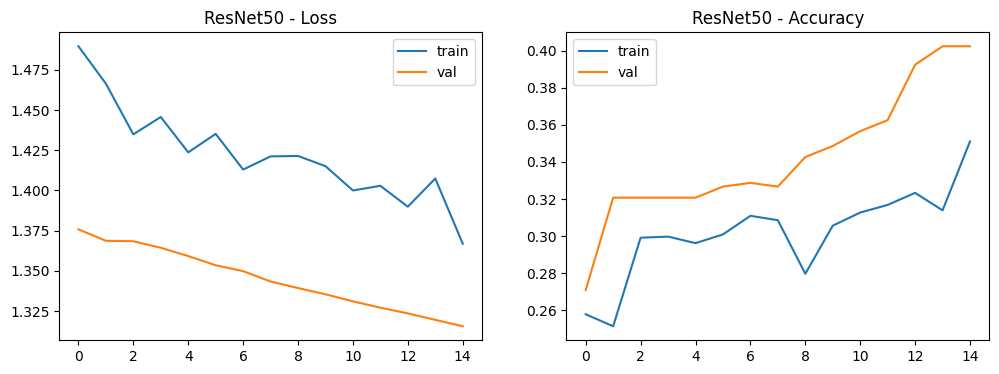


Training MobileNetV2 ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2587 - loss: 1.8009

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.2791 - loss: 1.7210 - val_accuracy: 0.3187 - val_loss: 1.6933
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2961 - loss: 1.6124

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3233 - loss: 1.5706 - val_accuracy: 0.3426 - val_loss: 1.5208
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3931 - loss: 1.4211

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3923 - loss: 1.4128 - val_accuracy: 0.3805 - val_loss: 1.4176
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3824 - loss: 1.3867

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4059 - loss: 1.3354 - val_accuracy: 0.4104 - val_loss: 1.3444
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4795 - loss: 1.2867

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4926 - loss: 1.2532 - val_accuracy: 0.4363 - val_loss: 1.2957
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4671 - loss: 1.2368

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4991 - loss: 1.2078 - val_accuracy: 0.4482 - val_loss: 1.2574
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5011 - loss: 1.1797

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5227 - loss: 1.1435 - val_accuracy: 0.4721 - val_loss: 1.2211
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5391 - loss: 1.1178

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5504 - loss: 1.0966 - val_accuracy: 0.4920 - val_loss: 1.1686
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5539 - loss: 1.0739

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5611 - loss: 1.0597 - val_accuracy: 0.5100 - val_loss: 1.1338
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5874 - loss: 1.0260

14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5894 - loss: 1.0305 - val_accuracy: 0.5239 - val_loss: 1.0956
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5618 - loss: 1.0093

14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5847 - loss: 0.9945 - val_accuracy: 0.5418 - val_loss: 1.0566
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5990 - loss: 0.9789

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6130 - loss: 0.9657 - val_accuracy: 0.5398 - val_loss: 1.0434
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6088 - loss: 0.9589

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6147 - loss: 0.9442 - val_accuracy: 0.5518 - val_loss: 1.0190
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6239 - loss: 0.9290

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6354 - loss: 0.9114 - val_accuracy: 0.5518 - val_loss: 0.9934
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6616 - loss: 0.8856

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6572 - loss: 0.8773 - val_accuracy: 0.5558 - val_loss: 0.9676


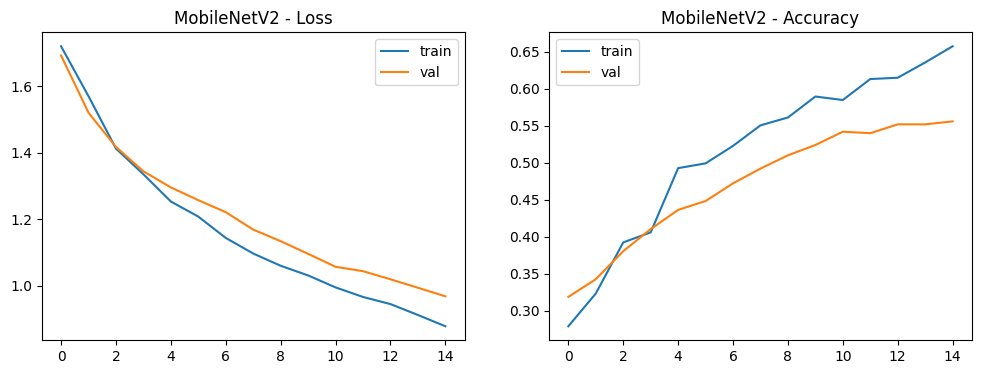


Training InceptionV3 ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2595 - loss: 1.6334

14/14 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.2749 - loss: 1.5794 - val_accuracy: 0.3247 - val_loss: 1.4144
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3261 - loss: 1.4512

14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.3622 - loss: 1.4107 - val_accuracy: 0.3984 - val_loss: 1.3079
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4012 - loss: 1.3638

14/14 ━━━━━━━━━━━━━━━━━━━━ 109s 8s/step - accuracy: 0.4053 - loss: 1.3373 - val_accuracy: 0.4562 - val_loss: 1.2197
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4487 - loss: 1.2622

14/14 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.4401 - loss: 1.2737 - val_accuracy: 0.5120 - val_loss: 1.1583
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4602 - loss: 1.2067

14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - accuracy: 0.4820 - loss: 1.2008 - val_accuracy: 0.5498 - val_loss: 1.0921
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4990 - loss: 1.1609

14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.5009 - loss: 1.1508 - val_accuracy: 0.5837 - val_loss: 1.0457
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5631 - loss: 1.0537

14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.5658 - loss: 1.0587 - val_accuracy: 0.5837 - val_loss: 1.0103
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5583 - loss: 1.0714

14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.5670 - loss: 1.0526 - val_accuracy: 0.6056 - val_loss: 0.9732
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6026 - loss: 1.0003

14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.5935 - loss: 0.9990 - val_accuracy: 0.6096 - val_loss: 0.9455
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5857 - loss: 1.0185

14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.5988 - loss: 0.9848 - val_accuracy: 0.6295 - val_loss: 0.9157
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6241 - loss: 0.9388

14/14 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - accuracy: 0.6142 - loss: 0.9483 - val_accuracy: 0.6494 - val_loss: 0.8932
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6191 - loss: 0.9480

14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.6260 - loss: 0.9325 - val_accuracy: 0.6574 - val_loss: 0.8755
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6202 - loss: 0.9249

14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.6171 - loss: 0.9229 - val_accuracy: 0.6653 - val_loss: 0.8621
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6434 - loss: 0.9086

14/14 ━━━━━━━━━━━━━━━━━━━━ 121s 9s/step - accuracy: 0.6342 - loss: 0.9232 - val_accuracy: 0.6753 - val_loss: 0.8472
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6479 - loss: 0.8830

14/14 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - accuracy: 0.6490 - loss: 0.8817 - val_accuracy: 0.6813 - val_loss: 0.8304


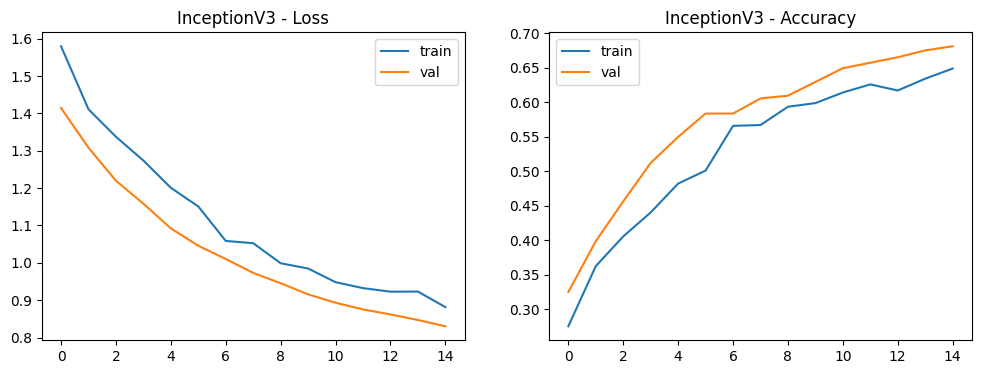

In [8]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


x:\Guviprojects\projectsss\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Guviprojects\projectsss\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Guviprojects\projectsss\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\G


📊 CustomCNN Results:
Accuracy=0.3252  Precision=0.1058  Recall=0.3252  F1=0.1596
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



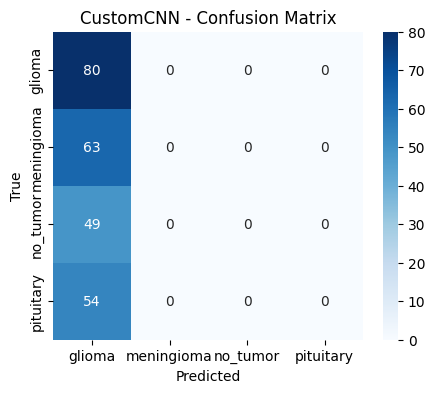

x:\Guviprojects\projectsss\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Guviprojects\projectsss\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Guviprojects\projectsss\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\G


📊 ResNet50 Results:
Accuracy=0.4106  Precision=0.2737  Recall=0.4106  F1=0.2841
              precision    recall  f1-score   support

      glioma       0.37      1.00      0.54        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.78      0.43      0.55        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.41       246
   macro avg       0.29      0.36      0.27       246
weighted avg       0.27      0.41      0.28       246



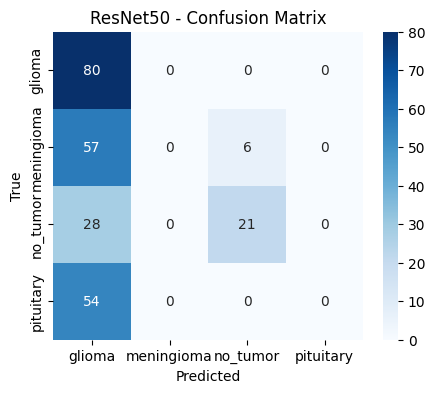


📊 MobileNetV2 Results:
Accuracy=0.6138  Precision=0.6870  Recall=0.6138  F1=0.6245
              precision    recall  f1-score   support

      glioma       0.93      0.62      0.75        80
  meningioma       0.46      0.79      0.58        63
    no_tumor       0.85      0.59      0.70        49
   pituitary       0.45      0.41      0.43        54

    accuracy                           0.61       246
   macro avg       0.67      0.60      0.61       246
weighted avg       0.69      0.61      0.62       246



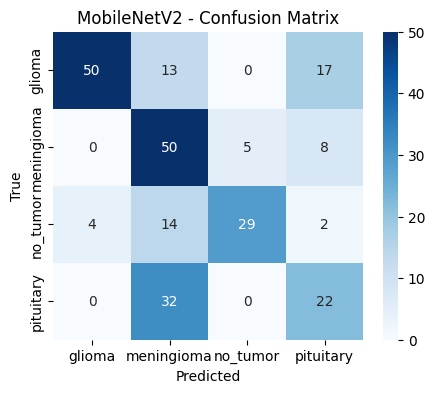


📊 InceptionV3 Results:
Accuracy=0.6951  Precision=0.7152  Recall=0.6951  F1=0.6816
              precision    recall  f1-score   support

      glioma       0.75      0.80      0.78        80
  meningioma       0.73      0.38      0.50        63
    no_tumor       0.79      0.67      0.73        49
   pituitary       0.58      0.93      0.71        54

    accuracy                           0.70       246
   macro avg       0.71      0.70      0.68       246
weighted avg       0.72      0.70      0.68       246



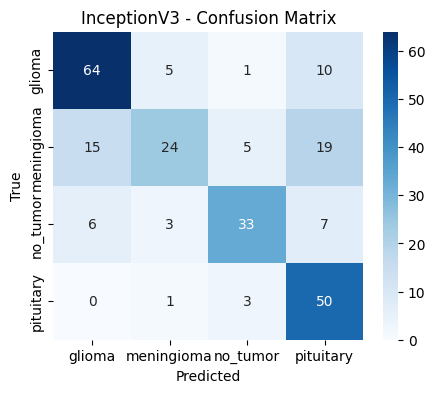

In [9]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
3  InceptionV3  0.695122   0.715239  0.695122  0.681587
2  MobileNetV2  0.613821   0.687041  0.613821  0.624546
1     ResNet50  0.410569   0.273719  0.410569  0.284099
0    CustomCNN  0.325203   0.105757  0.325203  0.159609


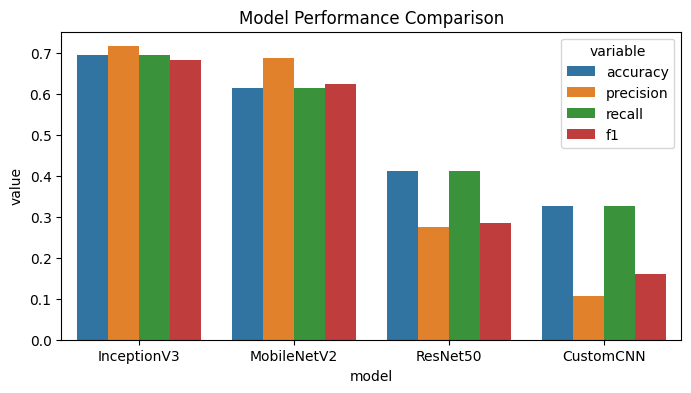


🏆 Best Performing Model: InceptionV3


In [10]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [11]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/InceptionV3_best.pkl
